In [1]:
import pickle
import numpy as np
from time import time
from sympy import default_sort_key
import matplotlib.pyplot as plt  

import warnings
warnings.filterwarnings('ignore')  # Ignore warnings

from discopy.tensor import Tensor
from discopy.rigid import Id
from discopy.quantum import Circuit

from lambeq.ccg2discocat import DepCCGParser
from lambeq.circuit import IQPAnsatz
from lambeq.tensor import SpiderAnsatz
from lambeq.core.types import AtomicType
from lambeq.ansatz import Symbol

from pytket.extensions.qiskit import AerBackend, IBMQBackend, IBMQEmulatorBackend

import helper_funcs as hlp

In [2]:
backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'n_shots': 2**13,
}

train_labels, train_data = hlp.read_data('mc_train_data.txt')
test_labels, test_data = hlp.read_data('mc_test_data.txt')

embedding = hlp.load_weights('trained_embeddings_new.pkl')
vocab = embedding['vocab']
vals = embedding['vals']

In [3]:
train_circs = hlp.build_circuits(train_data)
test_circs = hlp.build_circuits(test_data)

In [ ]:
def f(c1, c2):
    c1 = tk_to_qiskit(c1.to_tk())
    c2 = tk_to_qiskit(c2.to_tk())
    
    qr1 = QuantumRegister(c1.num_qubits, 'a')
    qr2 = QuantumRegister(c2.num_qubits, 'b')

    cr1 = ClassicalRegister(c1.num_clbits, 'c_a')
    cr2 = ClassicalRegister(c2.num_clbits, 'c_b')

    anc = QuantumRegister(1, 'ancilla')
    anc_cl = ClassicalRegister(1, 'c_ancilla')
    
    qc = QuantumCircuit(qr1, qr2, anc, cr1, cr2, anc_cl)
    
    qc = qc.compose(c1, qubits=range(qr1.size), clbits=range(cr1.size))
    qc = qc.compose(c2, qubits=range(qr1.size, qr1.size+qr2.size), clbits=range(cr1.size, cr1.size + cr2.size))
    
    qc.h(anc)
    qc.cswap(anc, 2, qr1.size + 2)
    qc.h(anc)
    qc.measure(anc, anc_cl)
    
    backend = Aer.get_backend('statevector_simulator')
    backend_sim = Aer.get_backend('qasm_simulator')

    job = backend_sim.run(transpile(qc, backend), shots=2**13)
    result = job.result()
    counts = result.get_counts()
    
    if '1 000 000' not in counts:
        counts['1 000 000'] = 0
    if '0 000 000' not in counts:
        counts['0 000 000'] = 0
    return np.array([counts['0 000 000'], counts['1 000 000']]) / (counts['0 000 000'] + counts['1 000 000'])


In [95]:
t1 = train_circs[0].lambdify(*vocab)(*vals)
t2 = train_circs[1].lambdify(*vocab)(*vals)
t3 = test_circs[2].lambdify(*vocab)(*vals)
print(train_labels[:2])
print(test_labels[2])

[[1 0]
 [1 0]]
[0 1]


In [169]:
from pytket import Circuit
from pytket.extensions.qiskit import AerBackend

In [218]:
def sim(c1, c2):
    tk1 = c1.to_tk()
    tk2 = c2.to_tk()
    
    qubit_mapper = list(range(tk1.n_qubits, tk1.n_qubits + tk2.n_qubits))
    bit_mapper = list(range(tk1.n_bits, tk1.n_bits + tk2.n_bits))
    
    tk2_new_post_selection = {q + tk1.n_bits : v for q, v in tk2.post_selection.items()}
    
    qc = tk1.add_circuit(tk2, qubit_mapper, bit_mapper)
    qc.post_select(tk2_new_post_selection)
    
    # Add 1 qubit and cbit circuit for ancillary bit
    anc = Circuit(1, 1)
    qc.add_circuit(anc, [qc.n_qubits], [qc.n_bits])
    
    anc_qubit = qc.n_qubits - 1
    anc_bit = qc.n_bits - 1
    qc.H(anc_qubit)
    
    control_qubit = qc.qubits[-1]
    target_qubits = []
    for qubit in qc.qubits[:-1]:
        if qubit not in qc.qubit_to_bit_map:
            target_qubits.append(qubit)
     
    qc.CSWAP(control_qubit, *target_qubits)
    qc.H(anc_qubit)
    
    qc.Measure(anc_qubit, anc_bit)
    return qc

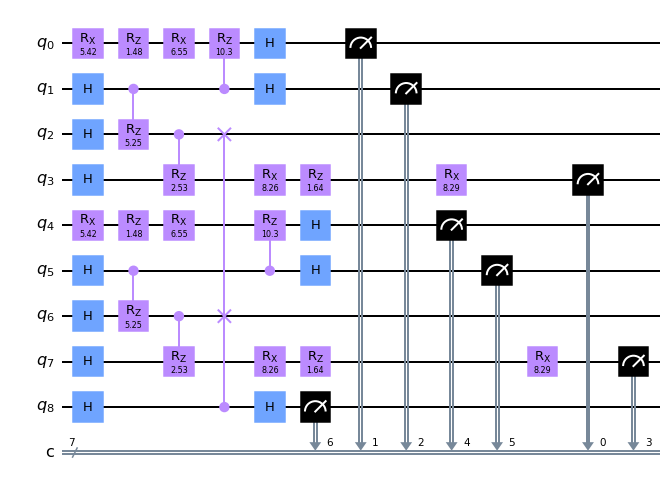

In [226]:
s = sim(t1, t1)
qis = tk_to_qiskit(s)
qis.draw('mpl')

In [198]:
tk1 = t1.to_tk()
tk2 = t2.to_tk()

In [199]:
tk1.post_selection

{0: 0, 1: 0, 2: 0}

In [200]:
qubit_mapper = list(range(tk1.n_qubits, tk1.n_qubits + tk2.n_qubits))
bit_mapper = list(range(tk1.n_bits, tk1.n_bits + tk2.n_bits))

tk2_post_selection = {q+tk1.n_bits: v for q, v in tk2.post_selection.items()}

qc = tk1.add_circuit(tk2, qubit_mapper, bit_mapper)
qc.post_select(tk2_post_selection)

tk.Circuit(8, 6).Rx(1.7253945787835865, 0).H(1).H(2).H(3).Rx(1.7253945787835865, 4).H(5).H(6).H(7).Rz(0.4717023887449417, 0).CRz(1.6702362483992, 1, 2).Rz(0.4717023887449417, 4).CRz(2.0740920011978226, 5, 6).Rx(2.084398691258283, 0).CRz(0.8047834553888495, 2, 3).Rx(2.084398691258283, 4).CRz(0.7500655337573157, 6, 7).CRz(3.281656761314131, 1, 0).Rx(2.630544871719448, 3).CRz(3.281656761314131, 5, 4).Rx(2.093304386604487, 7).H(0).H(1).Rz(0.5211918565205123, 3).H(4).H(5).Rz(1.7000315783320499, 7).Measure(0, 1).Measure(1, 2).Measure(4, 4).Measure(5, 5).Rx(2.6403004945595403, 3).Rx(3.4979786755631483, 7).Measure(3, 0).Measure(7, 3).post_select({0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0})

In [201]:
# qc.add_blank_wires(1)
# anc_qubit = qc.n_qubits-1
# qc.H(anc_qubit)
from pytket import Circuit
c = Circuit(1, 1)

qc.add_circuit(c, [qc.n_qubits], [qc.n_bits])

tk.Circuit(9, 7).Rx(1.7253945787835865, 0).H(1).H(2).H(3).Rx(1.7253945787835865, 4).H(5).H(6).H(7).Rz(0.4717023887449417, 0).CRz(1.6702362483992, 1, 2).Rz(0.4717023887449417, 4).CRz(2.0740920011978226, 5, 6).Rx(2.084398691258283, 0).CRz(0.8047834553888495, 2, 3).Rx(2.084398691258283, 4).CRz(0.7500655337573157, 6, 7).CRz(3.281656761314131, 1, 0).Rx(2.630544871719448, 3).CRz(3.281656761314131, 5, 4).Rx(2.093304386604487, 7).H(0).H(1).Rz(0.5211918565205123, 3).H(4).H(5).Rz(1.7000315783320499, 7).Measure(0, 1).Measure(1, 2).Measure(4, 4).Measure(5, 5).Rx(2.6403004945595403, 3).Rx(3.4979786755631483, 7).Measure(3, 0).Measure(7, 3).post_select({0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0})

In [202]:
anc_qubit = qc.n_qubits-1
anc_bit = qc.n_bits - 1
qc.H(anc_qubit)

tk.Circuit(9, 7).Rx(1.7253945787835865, 0).H(1).H(2).H(3).Rx(1.7253945787835865, 4).H(5).H(6).H(7).H(8).Rz(0.4717023887449417, 0).CRz(1.6702362483992, 1, 2).Rz(0.4717023887449417, 4).CRz(2.0740920011978226, 5, 6).Rx(2.084398691258283, 0).CRz(0.8047834553888495, 2, 3).Rx(2.084398691258283, 4).CRz(0.7500655337573157, 6, 7).CRz(3.281656761314131, 1, 0).Rx(2.630544871719448, 3).CRz(3.281656761314131, 5, 4).Rx(2.093304386604487, 7).H(0).H(1).Rz(0.5211918565205123, 3).H(4).H(5).Rz(1.7000315783320499, 7).Measure(0, 1).Measure(1, 2).Measure(4, 4).Measure(5, 5).Rx(2.6403004945595403, 3).Rx(3.4979786755631483, 7).Measure(3, 0).Measure(7, 3).post_select({0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0})

In [206]:
target_qubits = []
for qubit in qc.qubits[:-1]:
    if qubit not in qc.qubit_to_bit_map:
        target_qubits.append(qubit)

target_qubits

[q[2], q[6]]

In [208]:
qc.CSWAP(qc.qubits[-1], *target_qubits)

tk.Circuit(9, 7).Rx(1.7253945787835865, 0).H(1).H(2).H(3).Rx(1.7253945787835865, 4).H(5).H(6).H(7).H(8).Rz(0.4717023887449417, 0).CRz(1.6702362483992, 1, 2).Rz(0.4717023887449417, 4).CRz(2.0740920011978226, 5, 6).Rx(2.084398691258283, 0).CRz(0.8047834553888495, 2, 3).Rx(2.084398691258283, 4).CRz(0.7500655337573157, 6, 7).CRz(3.281656761314131, 1, 0).CSWAP(8, 2, 6).Rx(2.630544871719448, 3).CRz(3.281656761314131, 5, 4).Rx(2.093304386604487, 7).H(0).H(1).Rz(0.5211918565205123, 3).H(4).H(5).Rz(1.7000315783320499, 7).Measure(0, 1).Measure(1, 2).Measure(4, 4).Measure(5, 5).Rx(2.6403004945595403, 3).Rx(3.4979786755631483, 7).Measure(3, 0).Measure(7, 3).post_select({0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0})

In [209]:
qc.H(anc_qubit)

tk.Circuit(9, 7).Rx(1.7253945787835865, 0).H(1).H(2).H(3).Rx(1.7253945787835865, 4).H(5).H(6).H(7).H(8).Rz(0.4717023887449417, 0).CRz(1.6702362483992, 1, 2).Rz(0.4717023887449417, 4).CRz(2.0740920011978226, 5, 6).Rx(2.084398691258283, 0).CRz(0.8047834553888495, 2, 3).Rx(2.084398691258283, 4).CRz(0.7500655337573157, 6, 7).CRz(3.281656761314131, 1, 0).CSWAP(8, 2, 6).Rx(2.630544871719448, 3).CRz(3.281656761314131, 5, 4).Rx(2.093304386604487, 7).H(0).H(1).Rz(0.5211918565205123, 3).H(4).H(5).Rz(1.7000315783320499, 7).H(8).Measure(0, 1).Measure(1, 2).Measure(4, 4).Measure(5, 5).Rx(2.6403004945595403, 3).Rx(3.4979786755631483, 7).Measure(3, 0).Measure(7, 3).post_select({0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0})

In [210]:
# anc_bit = qc.n_bits - 1
qc.Measure(anc_qubit, anc_bit)


tk.Circuit(9, 7).Rx(1.7253945787835865, 0).H(1).H(2).H(3).Rx(1.7253945787835865, 4).H(5).H(6).H(7).H(8).Rz(0.4717023887449417, 0).CRz(1.6702362483992, 1, 2).Rz(0.4717023887449417, 4).CRz(2.0740920011978226, 5, 6).Rx(2.084398691258283, 0).CRz(0.8047834553888495, 2, 3).Rx(2.084398691258283, 4).CRz(0.7500655337573157, 6, 7).CRz(3.281656761314131, 1, 0).CSWAP(8, 2, 6).Rx(2.630544871719448, 3).CRz(3.281656761314131, 5, 4).Rx(2.093304386604487, 7).H(0).H(1).Rz(0.5211918565205123, 3).H(4).H(5).Rz(1.7000315783320499, 7).H(8).Measure(0, 1).Measure(1, 2).Measure(4, 4).Measure(5, 5).Measure(8, 6).Rx(2.6403004945595403, 3).Rx(3.4979786755631483, 7).Measure(3, 0).Measure(7, 3).post_select({0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0})

In [197]:
type(list(tk2.qubit_to_bit_map.items())[0][0])

pytket._tket.circuit.Qubit

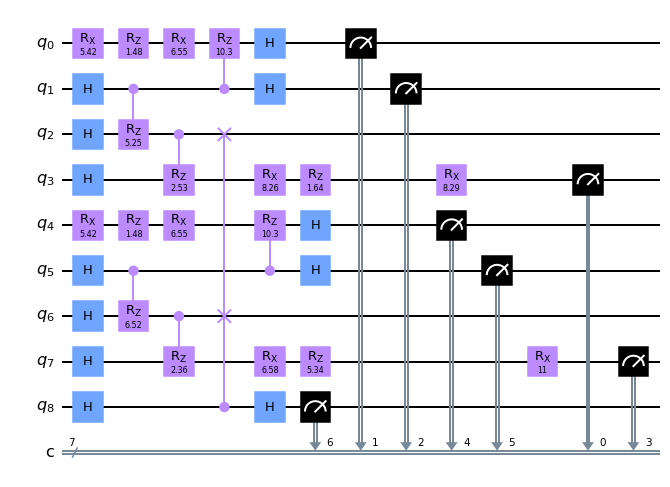

In [211]:
tk_to_qiskit(qc).draw('mpl')

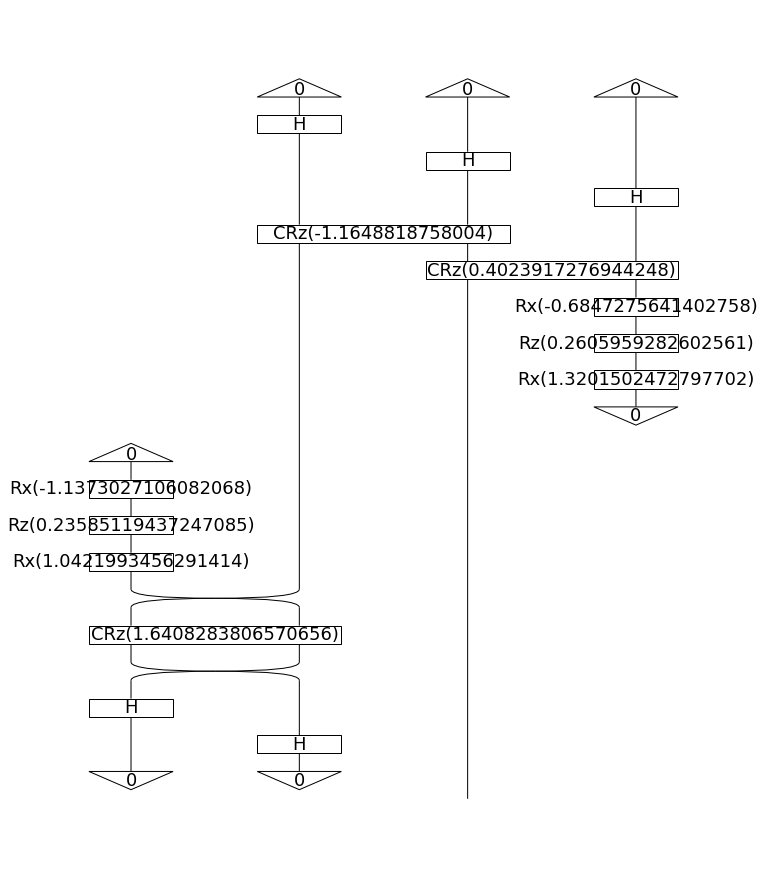

In [38]:
t1.draw(figsize=(9, 12))

In [26]:
t1.eval()

Tensor(dom=Dim(1), cod=Dim(2), array=[-0.35485028+0.07107087j, 0.01182535+0.03897462j])

In [192]:
print(train_data[0])
print(train_data[1])
print(test_data[2])

skillful man prepares sauce
skillful man bakes dinner
skillful woman prepares software


In [186]:
t1.eval()

Tensor(dom=Dim(1), cod=Dim(2), array=[-0.35485028+0.07107087j, 0.01182535+0.03897462j])

In [188]:
t2.eval()

Tensor(dom=Dim(1), cod=Dim(2), array=[0.03541215-0.28783681j, -0.01562783-0.03652152j])

In [193]:
t3.eval()

Tensor(dom=Dim(1), cod=Dim(2), array=[-0.05873117-0.04374749j, -0.22702531-0.23096538j])

In [57]:
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit
# t1_q = tk_to_qiskit(t1.to_tk())
# t2_q = tk_to_qiskit(t2.to_tk())
# t1_q = tk_to_qiskit(t3.to_tk())

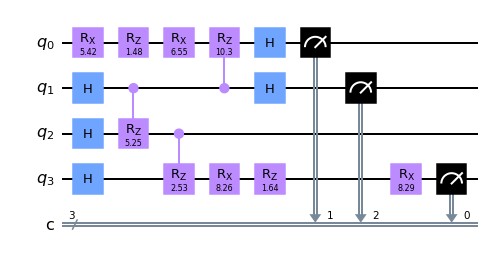

In [92]:
t1_q.draw('mpl')

In [75]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [116]:
qr1 = QuantumRegister(4, 'a')
qr2 = QuantumRegister(4, 'b')

cr1 = ClassicalRegister(3, 'c_a')
cr2 = ClassicalRegister(3, 'c_b')

anc = QuantumRegister(1, 'ancilla')
ancC = ClassicalRegister(1, 'c_ancilla')

In [117]:
qc = QuantumCircuit(qr1, qr2, anc, cr1, cr2, ancC)
# qc.draw('mpl')

In [118]:
qr1

QuantumRegister(4, 'a')

In [119]:
qc = qc.compose(t1_q, qubits=range(qr1.size), clbits=range(cr1.size))


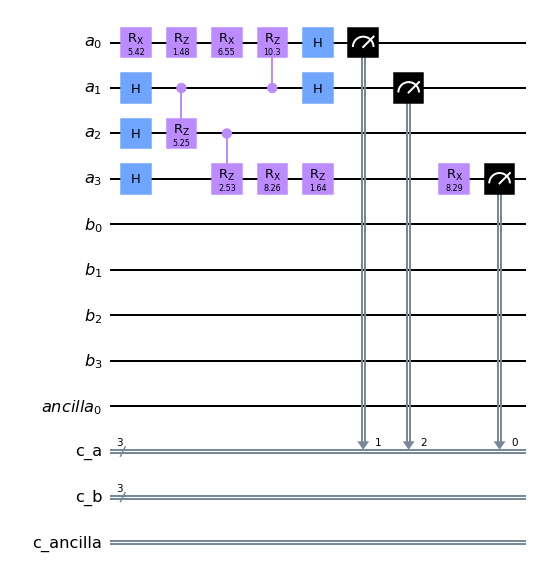

In [120]:
qc.draw('mpl')

In [121]:
qc = qc.compose(t2_q, qubits=range(qr1.size, qr1.size+qr2.size), clbits=range(cr1.size, cr1.size + cr2.size))

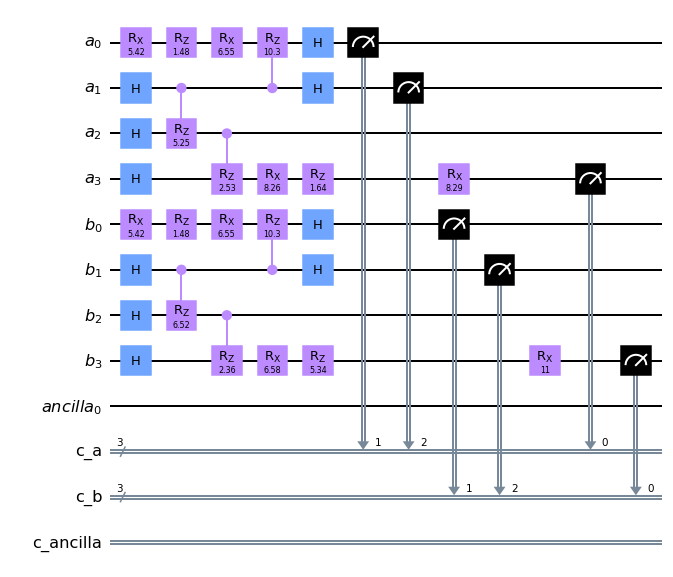

In [122]:
qc.draw('mpl')

In [114]:
qc.h(0)

In [123]:
qc.h(anc)

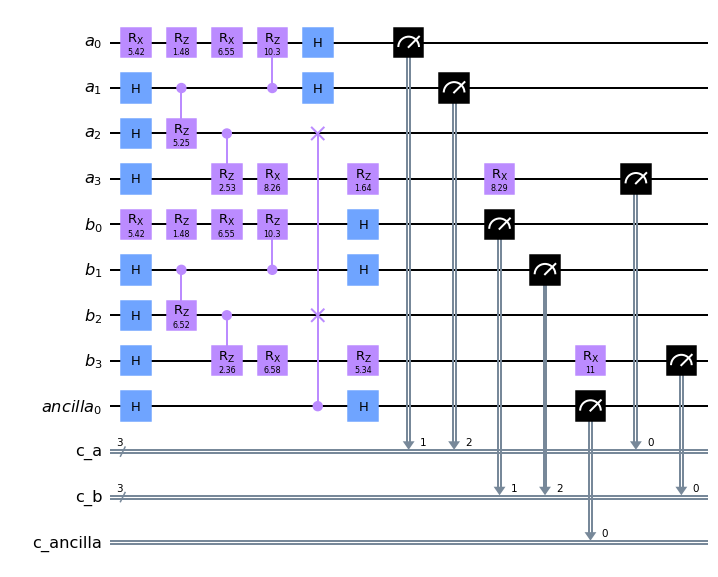

In [126]:
qc.cswap(anc, 2, qr1.size + 2)
qc.h(anc)
qc.measure(anc, ancC)
qc.draw('mpl')

In [140]:
from qiskit import Aer, transpile

backend = Aer.get_backend('statevector_simulator')
backend_sim = Aer.get_backend('qasm_simulator')

job = backend_sim.run(transpile(qc, backend), shots=2**20)
result = job.result()
counts = result.get_counts()

In [141]:
result

Result(backend_name='qasm_simulator', backend_version='0.9.1', qobj_id='fc232e1f-8cab-45a5-8e5c-84a455291d31', job_id='e2a76ddf-570c-4052-a0cf-6969430ede90', success=True, results=[ExperimentResult(shots=1048576, success=True, meas_level=2, data=ExperimentResultData(counts={'0x56': 13, '0x50': 31, '0x62': 8, '0x5f': 27, '0x59': 41, '0x4b': 67, '0x42': 18, '0x40': 98, '0x64': 143, '0x6f': 370, '0x79': 431, '0x69': 230, '0x5d': 79, '0x54': 32, '0x7d': 955, '0x11': 1348, '0x76': 249, '0x3': 1283, '0x51': 951, '0x23': 1511, '0x6d': 459, '0x29': 7586, '0x7f': 626, '0x74': 307, '0x5c': 1788, '0x4f': 208, '0x5b': 63, '0x6c': 3448, '0x41': 2635, '0x46': 96, '0x66': 143, '0x2c': 3921, '0x44': 158, '0x4': 5827, '0x70': 189, '0x53': 307, '0x12': 2807, '0xa': 5982, '0x3c': 10218, '0x18': 3894, '0x3a': 13818, '0x31': 10531, '0x1c': 2056, '0x6b': 80, '0x73': 2322, '0x25': 8027, '0x15': 2587, '0x32': 21901, '0x37': 37888, '0x6e': 9481, '0x3e': 31757, '0x77': 32125, '0xd': 16586, '0x6a': 4163, '0x7b':

In [144]:
np.array([counts['0 000 000'], counts['1 000 000']]) / (counts['0 000 000'] + counts['1 000 000'])

array([0.99176263, 0.00823737])

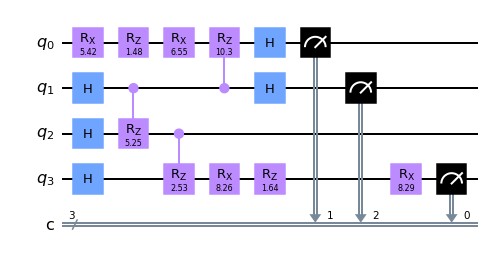

In [147]:
t1_q.draw('mpl')

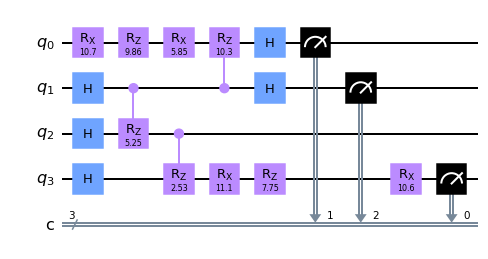

In [146]:
t3_q.draw('mpl')

In [179]:
def f(c1, c2):
    c1 = tk_to_qiskit(c1.to_tk())
    c2 = tk_to_qiskit(c2.to_tk())
    
    qr1 = QuantumRegister(c1.num_qubits, 'a')
    qr2 = QuantumRegister(c2.num_qubits, 'b')

    cr1 = ClassicalRegister(c1.num_clbits, 'c_a')
    cr2 = ClassicalRegister(c2.num_clbits, 'c_b')

    anc = QuantumRegister(1, 'ancilla')
    anc_cl = ClassicalRegister(1, 'c_ancilla')
    
    qc = QuantumCircuit(qr1, qr2, anc, cr1, cr2, anc_cl)
    
    qc = qc.compose(c1, qubits=range(qr1.size), clbits=range(cr1.size))
    qc = qc.compose(c2, qubits=range(qr1.size, qr1.size+qr2.size), clbits=range(cr1.size, cr1.size + cr2.size))
    
    qc.h(anc)
    qc.cswap(anc, 2, qr1.size + 2)
    qc.h(anc)
    qc.measure(anc, anc_cl)
    
    backend = Aer.get_backend('statevector_simulator')
    backend_sim = Aer.get_backend('qasm_simulator')

    job = backend_sim.run(transpile(qc, backend), shots=2**13)
    result = job.result()
    counts = result.get_counts()
    
    if '1 000 000' not in counts:
        counts['1 000 000'] = 0
    if '0 000 000' not in counts:
        counts['0 000 000'] = 0
    return np.array([counts['0 000 000'], counts['1 000 000']]) / (counts['0 000 000'] + counts['1 000 000'])


In [180]:
f(t1_q, t1_q)

array([1., 0.])

In [181]:
f(t1_q, t2_q)

array([1., 0.])

In [182]:
f(t1_q, t3_q)

array([0.52542373, 0.47457627])

In [175]:
print(train_data[0])
print(train_data[1])
print(test_data[2])

skillful man prepares sauce
skillful man bakes dinner
skillful woman prepares software
